# **Математика - Домашнее задание 8**

**Дедлайн:** 23:59, 27 января

### **Задание:**

Необходимо взять (или сгенерировать самому) датасет, в котором для достаточно большой целевой аудитории (абоненты или лояльные клиенты) представлены еженедельные метрики (тут на ваш выбор). Например, в течение 2-3 месяцев вы собирали, накапливали ваши данные. Далее используйте различные техники для проверки распределений ваших метрик (1 метрика - непрерывная, 2-я дискретная [можно взять бинарную]).

**Пример.** У меня есть 1 миллион юзеров Киона. Собираю по ним метрики за 12 недель (суммарное время просмотра за каждую неделю и флаг просмотра хотя бы одного фильма из какой-то категории). Далее сравниваем распределения метрик в динамике по разным неделям и делаем выводы о появлении отклонения (распределение начало изменяться или нет). Можно использовать техники, предложенные на занятии.

**Для получения зачета необходимо:**

**Зачет на 4:** рассмотрена только 1 метрика с незначительными замечаниями

**Зачет на 5:** рассмотрена непрерывная и дискретная метрика с незначительными замечаниями

#### Библиотеки

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as sts
from scipy import stats
from sklearn.preprocessing import LabelEncoder

# Настройка стиля
plt.style.use('classic')
palette = sns.color_palette("husl", 8)
%matplotlib inline

## Подготовка данных

#### **RecSys Course Competition**

[Link](https://ods.ai/competitions/competition-recsys-21)

Долго сомневался, можно ли брать или нет, так как Kion, но увидел, что коллеги используют, поэтому все-таки решился.

Вам предоставлены данные из приложения МТС Kion по взаимодействиям пользователей с контентом за период 6 месяцев.
В отдельных файлах есть:

- факты просмотра контента пользователями
- описание контента
- описание пользователей

In [6]:
df_interactions = pd.read_csv('interactions.csv')
df_items = pd.read_csv('items.csv')
df_users = pd.read_csv('users.csv')

In [7]:
df_interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [8]:
df_users = df_users.drop(['sex', 'kids_flg'], axis=1)
df_items = df_items.drop(['title', 'title_orig', 'genres', 'countries', 'for_kids', 'age_rating', 'studios', 
                                 'directors', 'actors', 'keywords', 'description', 'release_year', 'content_type'], axis=1)

In [9]:
df_merged = df_interactions.merge(df_items, how='left', on='item_id')

In [10]:
df_merged.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [11]:
df_merged = df_merged.drop(['item_id'], axis=1)
df_merged = df_merged.dropna()
df = df_merged

#### Деление по неделям 

In [13]:
df.head()

,user_id,last_watch_dt,total_dur,watched_pct
0,176549,2021-05-11,4250,72.0
1,699317,2021-05-29,8317,100.0
2,656683,2021-05-09,10,0.0
3,864613,2021-07-05,14483,100.0
4,964868,2021-04-30,6725,100.0


In [14]:
df['last_watch_dt'] = pd.to_datetime(df['last_watch_dt'])

df['week'] = df['last_watch_dt'].dt.strftime('%Y-%U')

grouped = df.groupby(['week', 'user_id']).agg({
    'total_dur': 'sum',
    'watched_pct': 'mean'})

In [15]:
grouped_reset = grouped.reset_index()
grouped_reset.head()

,week,user_id,total_dur,watched_pct
0,2021-10,46,10647,12.000000
1,2021-10,82,5661,79.000000
2,2021-10,83,1222,18.000000
3,2021-10,133,960,4.666667
4,2021-10,571,2741,56.000000


In [16]:
df = grouped_reset.merge(df_users, how='left', on='user_id')
df

,week,user_id,total_dur,watched_pct,age,income
0,2021-10,46,10647,12.000000,age_25_34,income_20_40
1,2021-10,82,5661,79.000000,age_25_34,income_40_60
2,2021-10,83,1222,18.000000,age_45_54,income_90_150
3,2021-10,133,960,4.666667,age_25_34,income_40_60
4,2021-10,571,2741,56.000000,age_25_34,income_40_60
...,...,...,...,...,...,...
2351707,2021-34,1097479,10993,1.000000,age_18_24,income_20_40
2351708,2021-34,1097502,1387,12.000000,age_18_24,income_20_40
2351709,2021-34,1097508,2464,4.500000,age_18_24,income_40_60
2351710,2021-34,1097521,1577,35.000000,age_25_34,income_20_40


In [17]:
df = df.dropna()

In [18]:
# Проверю пропуски
pd.isnull(df).sum()

week           0
user_id        0
total_dur      0
watched_pct    0
age            0
income         0
dtype: int64

In [19]:
# Проверка типов данных
df.dtypes

week            object
user_id          int64
total_dur        int64
watched_pct    float64
age             object
income          object
dtype: object

In [20]:
df['age'].unique()

# array(['age_25_34', 'age_45_54', 'age_35_44', 'age_18_24', 'age_55_64',
#        'age_65_inf'], dtype=object)

array(['age_25_34', 'age_45_54', 'age_35_44', 'age_18_24', 'age_55_64',
       'age_65_inf'], dtype=object)

Закодирую возраст стандартно Label Encoder - так как в целом мы не переживаем, что данные по возрастным группам приобретут некий смысл возрастани

In [22]:
age_categories = np.array(['age_25_34', 'age_45_54', 'age_35_44', 'age_18_24', 
                           'age_55_64', 'age_65_inf'])

label_encoder = LabelEncoder()
encoded_ages = label_encoder.fit_transform(age_categories)

df_age = pd.DataFrame({'age': age_categories})

# Кодирование
df_age['age_encoded'] = label_encoder.transform(df_age['age'])
df_age = df_age.sort_values(by=['age_encoded'], ascending=True)
df_age

,age,age_encoded
3,age_18_24,0
0,age_25_34,1
2,age_35_44,2
1,age_45_54,3
4,age_55_64,4
5,age_65_inf,5


In [23]:
df = df.merge(df_age, how='left', on='age')
df

,week,user_id,total_dur,watched_pct,age,income,age_encoded
0,2021-10,46,10647,12.000000,age_25_34,income_20_40,1
1,2021-10,82,5661,79.000000,age_25_34,income_40_60,1
2,2021-10,83,1222,18.000000,age_45_54,income_90_150,3
3,2021-10,133,960,4.666667,age_25_34,income_40_60,1
4,2021-10,571,2741,56.000000,age_25_34,income_40_60,1
...,...,...,...,...,...,...,...
1862752,2021-34,1097479,10993,1.000000,age_18_24,income_20_40,0
1862753,2021-34,1097502,1387,12.000000,age_18_24,income_20_40,0
1862754,2021-34,1097508,2464,4.500000,age_18_24,income_40_60,0
1862755,2021-34,1097521,1577,35.000000,age_25_34,income_20_40,1


In [24]:
pd.isnull(df).sum()

week           0
user_id        0
total_dur      0
watched_pct    0
age            0
income         0
age_encoded    0
dtype: int64

## Перехожу к анализу

### Какие метрики планирую анализировать?

Хочу оценить в качестве количественной метрики total_dur - общая продолжительность всех просмотров данного контента в секундах.

В качестве дискретной метрики age (age_encoded) - возрастная группа пользователя (группы age_18_24, age_25_34, age_35_44, age_45_54, age_55_64, age_65_inf)


### **Нетривиальный вопрос - а какой уровень значимости**

"При выборе критического уровня значимости необходимо обращать внимание на объем выборки. Общая идея тут следующая. При малом объеме выборки более вероятно получить случайный  результат, например, получить различие в двух в выборках при их однородности.  Следовательно, можно взять большую вероятность ошибки первого рода. При увеличении объема выборки случайные отклонения компенсируют друг друга, и получить значимое различие в выборках при их однородности менее вероятно. Следовательно, надо брать меньший уровень значимости. Стандартными уровнями значимости являются 0,1; 0,05; 0,01; 0,001. Поэтому нельзя всегда брать уровень значимость 0,05. Можно придерживаться следующих условных границ зависимости объема выборки от уровня значимости. Если объем выборки небольшой до 100 единиц, то можно вполне отвергнуть нулевую гипотезу при уровне значимости 0,05 или даже 0,1. При объеме выборки, измеряемой сотнями – от 100 до 1000, следует понизить уровень значимости хотя бы до 0,01. А при больших выборках, измеряемых тысячами наблюдений, уверенно отвергать нулевую гипотезу можно только при значимости меньшей 0,001."

#### **Предлагаю рассмотреть уровень значимости, равный 0,001.**

In [27]:
alpha = 0.001

#### Вытащу данные по первым 12 неделям

In [29]:
df_week_1 = df.query('week == "2021-10"')
df_week_2 = df.query('week == "2021-11"')
df_week_3 = df.query('week == "2021-12"')
df_week_4 = df.query('week == "2021-13"')
df_week_5 = df.query('week == "2021-14"')
df_week_6 = df.query('week == "2021-15"')
df_week_7 = df.query('week == "2021-16"')
df_week_8 = df.query('week == "2021-17"')
df_week_9 = df.query('week == "2021-18"')
df_week_10 = df.query('week == "2021-19"')
df_week_11 = df.query('week == "2021-20"')
df_week_12 = df.query('week == "2021-21"')

## Проверка распределения для непрерывной метрики

### **Формируем гипотезы!**

#### Двухвыборочная гипотеза о распределении для непрерывного случая (**Двувыборочный тест Колмогорова-Смирнова**):

Посмотрим на схожесть распределений в двух выборках (для непрерывного случая)

Будем смотреть на total_dur - общая продолжительность всех просмотров данного контента в секундах.

**ПОЧЕМУ?** Критерий работает для непрерывных распределений

**ФОРМУЛИРОВКА:** Идентичны ли распределения в двух выборках (выборках A и B)?
Под выборками A и B подразумеваются попарные сравнения выборок, соответствующих каждой неделе из общего набора данных.
То есть, мы сравниваем данные за неделю 1 и данные за неделю 2; данные за неделю 2 и за неделю 3 и так далее.

То есть, мы сравниваем распределения метрик в динамике по разным неделям и делаем выводы о появлении отклонения (распределение начало изменяться или нет). 

$H_0$ - выборки A и B проведенного за просмотром контента времени к нам пришли из некоторого распределения $F_0$, идентичного по параметрам.

$H_1$ - выборки A и B проведенного за просмотром контента времени к нам НЕ пришли из некоторого распределения $F_0$, идентичного по параметрам.

$$
\begin{aligned}
H_0 : X \sim F_0 \\
H_1 : X \nsim F_0
\end{aligned}
$$

### Посмотрим на распределения

<Axes: xlabel='total_dur', ylabel='Density'>

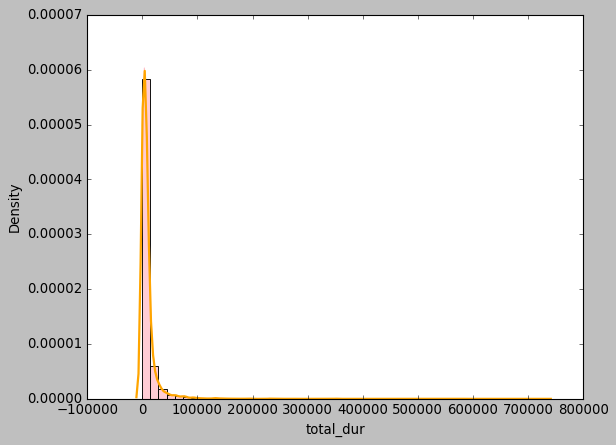

In [33]:
sns.histplot(df_week_1['total_dur'], bins=50, kde=True, color="pink", edgecolor="black", alpha=0.8, stat="density")
sns.kdeplot(df_week_1['total_dur'], color="orange", linewidth=2)

### Перейдем к тестам - вряд ли мы что-то заметим визуально.

In [35]:
print(sts.ks_2samp(df_week_1['total_dur'], df_week_2['total_dur'], alternative='two-sided'))
print(sts.ks_2samp(df_week_2['total_dur'], df_week_3['total_dur'], alternative='two-sided'))
print(sts.ks_2samp(df_week_3['total_dur'], df_week_4['total_dur'], alternative='two-sided'))
print(sts.ks_2samp(df_week_4['total_dur'], df_week_5['total_dur'], alternative='two-sided'))
print(sts.ks_2samp(df_week_5['total_dur'], df_week_6['total_dur'], alternative='two-sided'))
print(sts.ks_2samp(df_week_6['total_dur'], df_week_7['total_dur'], alternative='two-sided'))
print(sts.ks_2samp(df_week_7['total_dur'], df_week_8['total_dur'], alternative='two-sided'))
print(sts.ks_2samp(df_week_8['total_dur'], df_week_9['total_dur'], alternative='two-sided'))
print(sts.ks_2samp(df_week_9['total_dur'], df_week_10['total_dur'], alternative='two-sided'))
print(sts.ks_2samp(df_week_10['total_dur'], df_week_11['total_dur'], alternative='two-sided'))
print(sts.ks_2samp(df_week_11['total_dur'], df_week_12['total_dur'], alternative='two-sided'))

KstestResult(statistic=0.08288135141829678, pvalue=1.961787071652088e-42, statistic_location=12592, statistic_sign=1)
KstestResult(statistic=0.02123939996448221, pvalue=1.5403355736440815e-07, statistic_location=4861, statistic_sign=-1)
KstestResult(statistic=0.006321164277482638, pvalue=0.46855107745424596, statistic_location=3977, statistic_sign=-1)
KstestResult(statistic=0.02466385655052128, pvalue=6.364527073716579e-10, statistic_location=7157, statistic_sign=1)
KstestResult(statistic=0.015641813684124317, pvalue=0.0003183892630692439, statistic_location=9595, statistic_sign=1)
KstestResult(statistic=0.0658873983178036, pvalue=6.98332225506252e-83, statistic_location=3026, statistic_sign=-1)
KstestResult(statistic=0.048330352187513914, pvalue=7.65188018722706e-60, statistic_location=630, statistic_sign=1)
KstestResult(statistic=0.03438548029573485, pvalue=1.5022550394673968e-31, statistic_location=10512, statistic_sign=1)
KstestResult(statistic=0.010611059353419772, pvalue=0.002320

## Результаты теста Колмогорова-Смирнова

| Неделя     | p-value                | Сравнение с alpha = 0.001 | H₀ принимается | Интерпретация                                                                                           |
|------------|------------------------|---------------------------|----------------|-------------------------------------------------------------------------------------------------------|
| Неделя 1-2 | 1.96e-42              | p < 0.001                | Нет            | H₁: Выборки A и B времени просмотра пришли из распределений, которые **не идентичны** по параметрам.  |
| Неделя 2-3 | 1.54e-7               | p < 0.001                | Нет            | H₁: Выборки A и B времени просмотра пришли из распределений, которые **не идентичны** по параметрам.  |
| Неделя 3-4 | 0.46855               | p >= 0.001               | Да             | H₀: Выборки A и B времени просмотра пришли из распределения F₀, **идентичного** по параметрам.        |
| Неделя 4-5 | 6.36e-10              | p < 0.001                | Нет            | H₁: Выборки A и B времени просмотра пришли из распределений, которые **не идентичны** по параметрам.  |
| Неделя 5-6 | 0.000318              | p < 0.001                | Нет            | H₁: Выборки A и B времени просмотра пришли из распределений, которые **не идентичны** по параметрам.  |
| Неделя 6-7 | 6.98e-83              | p < 0.001                | Нет            | H₁: Выборки A и B времени просмотра пришли из распределений, которые **не идентичны** по параметрам.  |
| Неделя 7-8 | 7.65e-60              | p < 0.001                | Нет            | H₁: Выборки A и B времени просмотра пришли из распределений, которые **не идентичны** по параметрам.  |
| Неделя 8-9 | 1.50e-31              | p < 0.001                | Нет            | H₁: Выборки A и B времени просмотра пришли из распределений, которые **не идентичны** по параметрам.  |
| Неделя 9-10| 0.00232               | p >= 0.001               | Да             | H₀: Выборки A и B времени просмотра пришли из распределения F₀, **идентичного** по параметрам.        |
| Неделя 10-11| 0.02229              | p >= 0.001               | Да             | H₀: Выборки A и B времени просмотра пришли из распределения F₀, **идентичного** по параметрам.        |
| Неделя 11-12| 6.07e-6              | p < 0.001                | Нет            | H₁: Выборки A и B времени просмотра пришли из распределений, которые **не идентичны** по параметрам.  |


#### Таким образом

Т. о., гипотеза об идентичности распределения не отвергается только для недели 3-4 (уверенно), для недели 9-10 и 10-11 (не так уверенно, так как p-value все равно крайне низкий, не отвергаем только из-за скорректированного на объем выборки уровня значимости).

##### То есть, распределения сразу же начали меняться; но при этом гипотетическую модель нам не нужно было бы корректировать каждую неделю, так как есть интервалы, когда оно остается идентичным по параметрам.

### А давайте, допустим, посмотрим на кумулятивную сумму средних! 

In [39]:
size = len(df)
# Считаем кумулятивную сумму
df_week_1_cumsum = np.cumsum(df['total_dur'])
# Делим на число наблюдений
df_week_1_cumsum_mean = df_week_1_cumsum / np.arange(1, size + 1)

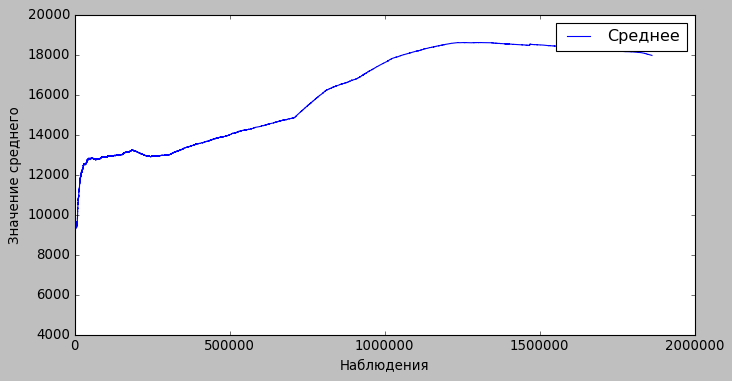

In [40]:
plt.figure(figsize=(10,5))
plt.plot(df_week_1_cumsum_mean)
plt.xlabel('Наблюдения')
plt.ylabel('Значение среднего')
plt.legend(['Среднее']) 

### Выводы: судя по графику, средние и правда разнятся от недели к неделе.

#### Двухвыборочная гипотеза о медиане для непрерывного случая (**Критерий Уилкоксона-Манна-Уитни**):

Давайте предположим, что сама функциональная форма значимо не меняется. А что насчет сдвига в распределениях?

Подходит, так как оценим значимость сдвига распределений + для независимых выборок.

 $H_0$ - $F_X(x) = F_Y(x)$ (Наш критерий проверяет гипотезу о равенстве функций распределения двух выборок против альтернативной гипотезы об их сдвиге.; между выборками нет статистически значимого сдвига)

$H_1$ - $F_X(x) = F_Y(x+m), m\neq0$ (между выборками есть статистически значимый сдвиг)

In [43]:
print(stats.mannwhitneyu(df_week_1['total_dur'], df_week_2['total_dur'], alternative='two-sided'))
print(stats.mannwhitneyu(df_week_2['total_dur'], df_week_3['total_dur'], alternative='two-sided'))
print(stats.mannwhitneyu(df_week_3['total_dur'], df_week_4['total_dur'], alternative='two-sided'))
print(stats.mannwhitneyu(df_week_4['total_dur'], df_week_5['total_dur'], alternative='two-sided'))
print(stats.mannwhitneyu(df_week_5['total_dur'], df_week_6['total_dur'], alternative='two-sided'))
print(stats.mannwhitneyu(df_week_6['total_dur'], df_week_7['total_dur'], alternative='two-sided'))
print(stats.mannwhitneyu(df_week_7['total_dur'], df_week_8['total_dur'], alternative='two-sided'))
print(stats.mannwhitneyu(df_week_8['total_dur'], df_week_9['total_dur'], alternative='two-sided'))
print(stats.mannwhitneyu(df_week_9['total_dur'], df_week_10['total_dur'], alternative='two-sided'))
print(stats.mannwhitneyu(df_week_10['total_dur'], df_week_11['total_dur'], alternative='two-sided'))
print(stats.mannwhitneyu(df_week_11['total_dur'], df_week_12['total_dur'], alternative='two-sided'))

MannwhitneyuResult(statistic=151452912.5, pvalue=1.5568482950701324e-10)
MannwhitneyuResult(statistic=669591910.0, pvalue=3.460416262850338e-05)
MannwhitneyuResult(statistic=642756616.5, pvalue=0.7526382244441814)
MannwhitneyuResult(statistic=633540472.5, pvalue=3.065129991302497e-05)
MannwhitneyuResult(statistic=628011142.0, pvalue=0.00069457963888986)
MannwhitneyuResult(statistic=1105065854.0, pvalue=2.27621950093063e-118)
MannwhitneyuResult(statistic=1609189888.0, pvalue=2.6676747371931165e-72)
MannwhitneyuResult(statistic=1765071213.5, pvalue=5.492364409958832e-31)
MannwhitneyuResult(statistic=1816292407.0, pvalue=0.0049630339241563655)
MannwhitneyuResult(statistic=1728323719.0, pvalue=0.03424576005462095)
MannwhitneyuResult(statistic=1875800683.0, pvalue=3.844164187739716e-07)


# Результаты теста Манна-Уитни

| Неделя     | p-value                | Сравнение с alpha = 0.001 | H₀ принимается | Интерпретация                                                                                           |
|------------|------------------------|---------------------------|----------------|-------------------------------------------------------------------------------------------------------|
| Неделя 1-2 | 1.56e-10               | p < 0.001                | Нет            | H₁: Между выборками есть статистически значимый сдвиг.                                                   |
| Неделя 2-3 | 3.46e-5                | p < 0.001                | Нет            | H₁: Между выборками есть статистически значимый сдвиг.                                                   |
| Неделя 3-4 | 0.75264                | p >= 0.001               | Да             | H₀: Между выборками нет статистически значимого сдвига.                                                 |
| Неделя 4-5 | 3.07e-5                | p < 0.001                | Нет            | H₁: Между выборками есть статистически значимый сдвиг.                                                   |
| Неделя 5-6 | 0.000695               | p < 0.001                | Нет            | H₁: Между выборками есть статистически значимый сдвиг.                                                   |
| Неделя 6-7 | 2.28e-118              | p < 0.001                | Нет            | H₁: Между выборками есть статистически значимый сдвиг.                                                   |
| Неделя 7-8 | 2.67e-72               | p < 0.001                | Нет            | H₁: Между выборками есть статистически значимый сдвиг.                                                   |
| Неделя 8-9 | 5.49e-31               | p < 0.001                | Нет            | H₁: Между выборками есть статистически значимый сдвиг.                                                   |
| Неделя 9-10| 0.00496                | p >= 0.001               | Да             | H₀: Между выборками нет статистически значимого сдвига.                                                 |
| Неделя 10-11| 0.03425               | p >= 0.001               | Да             | H₀: Между выборками нет статистически значимого сдвига.                                                 |
| Неделя 11-12| 3.84e-7               | p < 0.001                | Нет            | H₁: Между выборками есть статистически значимый сдвиг.                                                   |


### Таким образом, результаты аналогичны тесту Колмогорова-Смирнова

Т. о., гипотеза об идентичности распределения не отвергается только для недели 3-4 (уверенно), для недели 9-10 и 10-11 (не так уверенно, так как p-value все равно крайне низкий, не отвергаем только из-за скорректированного на объем выборки уровня значимости).

## Двухвыборочная гипотеза о распределении для дискретного случая (**Критерий Пирсона**):

**Гипотеза о неизвестном законе распределения:** 

$H_0$ - возрастные группы пользователей к нам пришли из некоторого распределения $F_0$, идентичного по параметрам.

$H_1$ - возрастные группы пользователей к нам НЕ пришли из некоторого распределения $F_0$, идентичного по параметрам.

$$
\begin{aligned}
H_0 : X \sim F_0 \\
H_1 : X \nsim F_0
\end{aligned}
$$

In [47]:
# Недели 1 и 2
df_week_1_age_encoded = df_week_1['age_encoded']
df_week_2_age_encoded = df_week_2['age_encoded']

df_week_1_age_encoded_counts = df_week_1_age_encoded.value_counts().sort_index()
df_week_2_age_encoded_counts = df_week_2_age_encoded.value_counts().sort_index()


contingency_table_1_2 = pd.DataFrame({
    'Health': df_week_1_age_encoded_counts,
    'Business': df_week_2_age_encoded_counts
})


# Недели 2 и 3
df_week_2_age_encoded = df_week_2['age_encoded']
df_week_3_age_encoded = df_week_3['age_encoded']

df_week_2_age_encoded_counts = df_week_2_age_encoded.value_counts().sort_index()
df_week_3_age_encoded_counts = df_week_3_age_encoded.value_counts().sort_index()

contingency_table_2_3 = pd.DataFrame({
    'Week 2': df_week_2_age_encoded_counts,
    'Week 3': df_week_3_age_encoded_counts
})

# Недели 3 и 4
df_week_3_age_encoded = df_week_3['age_encoded']
df_week_4_age_encoded = df_week_4['age_encoded']

df_week_3_age_encoded_counts = df_week_3_age_encoded.value_counts().sort_index()
df_week_4_age_encoded_counts = df_week_4_age_encoded.value_counts().sort_index()

contingency_table_3_4 = pd.DataFrame({
    'Week 3': df_week_3_age_encoded_counts,
    'Week 4': df_week_4_age_encoded_counts
})

# Недели 4 и 5
df_week_4_age_encoded = df_week_4['age_encoded']
df_week_5_age_encoded = df_week_5['age_encoded']

df_week_4_age_encoded_counts = df_week_4_age_encoded.value_counts().sort_index()
df_week_5_age_encoded_counts = df_week_5_age_encoded.value_counts().sort_index()

contingency_table_4_5 = pd.DataFrame({
    'Week 4': df_week_4_age_encoded_counts,
    'Week 5': df_week_5_age_encoded_counts
})

# Недели 5 и 6
df_week_5_age_encoded = df_week_5['age_encoded']
df_week_6_age_encoded = df_week_6['age_encoded']

df_week_5_age_encoded_counts = df_week_5_age_encoded.value_counts().sort_index()
df_week_6_age_encoded_counts = df_week_6_age_encoded.value_counts().sort_index()

contingency_table_5_6 = pd.DataFrame({
    'Week 5': df_week_5_age_encoded_counts,
    'Week 6': df_week_6_age_encoded_counts
})

# Недели 6 и 7
df_week_6_age_encoded = df_week_6['age_encoded']
df_week_7_age_encoded = df_week_7['age_encoded']

df_week_6_age_encoded_counts = df_week_6_age_encoded.value_counts().sort_index()
df_week_7_age_encoded_counts = df_week_7_age_encoded.value_counts().sort_index()

contingency_table_6_7 = pd.DataFrame({
    'Week 6': df_week_6_age_encoded_counts,
    'Week 7': df_week_7_age_encoded_counts
})

# Недели 7 и 8
df_week_7_age_encoded = df_week_7['age_encoded']
df_week_8_age_encoded = df_week_8['age_encoded']

df_week_7_age_encoded_counts = df_week_7_age_encoded.value_counts().sort_index()
df_week_8_age_encoded_counts = df_week_8_age_encoded.value_counts().sort_index()

contingency_table_7_8 = pd.DataFrame({
    'Week 7': df_week_7_age_encoded_counts,
    'Week 8': df_week_8_age_encoded_counts
})

# Недели 8 и 9
df_week_8_age_encoded = df_week_8['age_encoded']
df_week_9_age_encoded = df_week_9['age_encoded']

df_week_8_age_encoded_counts = df_week_8_age_encoded.value_counts().sort_index()
df_week_9_age_encoded_counts = df_week_9_age_encoded.value_counts().sort_index()

contingency_table_8_9 = pd.DataFrame({
    'Week 8': df_week_8_age_encoded_counts,
    'Week 9': df_week_9_age_encoded_counts
})

# Недели 9 и 10
df_week_9_age_encoded = df_week_9['age_encoded']
df_week_10_age_encoded = df_week_10['age_encoded']

df_week_9_age_encoded_counts = df_week_9_age_encoded.value_counts().sort_index()
df_week_10_age_encoded_counts = df_week_10_age_encoded.value_counts().sort_index()

contingency_table_9_10 = pd.DataFrame({
    'Week 9': df_week_9_age_encoded_counts,
    'Week 10': df_week_10_age_encoded_counts
})

# Недели 10 и 11
df_week_10_age_encoded = df_week_10['age_encoded']
df_week_11_age_encoded = df_week_11['age_encoded']

df_week_10_age_encoded_counts = df_week_10_age_encoded.value_counts().sort_index()
df_week_11_age_encoded_counts = df_week_11_age_encoded.value_counts().sort_index()

contingency_table_10_11 = pd.DataFrame({
    'Week 10': df_week_10_age_encoded_counts,
    'Week 11': df_week_11_age_encoded_counts
})

# Недели 11 и 12
df_week_11_age_encoded = df_week_11['age_encoded']
df_week_12_age_encoded = df_week_12['age_encoded']

df_week_11_age_encoded_counts = df_week_11_age_encoded.value_counts().sort_index()
df_week_12_age_encoded_counts = df_week_12_age_encoded.value_counts().sort_index()

contingency_table_11_12 = pd.DataFrame({
    'Week 11': df_week_11_age_encoded_counts,
    'Week 12': df_week_12_age_encoded_counts
})

In [48]:
# Chi-square test для таблицы 1-2
print(stats.chi2_contingency(contingency_table_1_2.T))

# Chi-square test для таблицы 2-3
print(stats.chi2_contingency(contingency_table_2_3.T))

# Chi-square test для таблицы 3-4
print(stats.chi2_contingency(contingency_table_3_4.T))

# Chi-square test для таблицы 4-5
print(stats.chi2_contingency(contingency_table_4_5.T))

# Chi-square test для таблицы 5-6
print(stats.chi2_contingency(contingency_table_5_6.T))

# Chi-square test для таблицы 6-7
print(stats.chi2_contingency(contingency_table_6_7.T))

# Chi-square test для таблицы 7-8
print(stats.chi2_contingency(contingency_table_7_8.T))

# Chi-square test для таблицы 8-9
print(stats.chi2_contingency(contingency_table_8_9.T))

# Chi-square test для таблицы 9-10
print(stats.chi2_contingency(contingency_table_9_10.T))

# Chi-square test для таблицы 10-11
print(stats.chi2_contingency(contingency_table_10_11.T))

# Chi-square test для таблицы 11-12
print(stats.chi2_contingency(contingency_table_11_12.T))

Chi2ContingencyResult(statistic=9.158830840223896, pvalue=0.10289418407483426, dof=5, expected_freq=array([[ 1307.2083592 ,  2343.93984479,  2435.064102  ,  1576.33381375,
          683.23886918,   361.21501109],
       [ 5463.7916408 ,  9797.06015521, 10177.935898  ,  6588.66618625,
         2855.76113082,  1509.78498891]]))
Chi2ContingencyResult(statistic=9.856892696191325, pvalue=0.07939317731426271, dof=5, expected_freq=array([[ 5446.23359385,  9727.67448207, 10142.02365298,  6661.18963735,
         2927.53239879,  1488.34623496],
       [ 5410.76640615,  9664.32551793, 10075.97634702,  6617.81036265,
         2908.46760121,  1478.65376504]]))
Chi2ContingencyResult(statistic=10.890276363549944, pvalue=0.05359940754377937, dof=5, expected_freq=array([[ 5373.59411363,  9647.78059895, 10147.09909558,  6576.79549604,
         2923.85997575,  1486.87072005],
       [ 5291.40588637,  9500.21940105,  9991.90090442,  6476.20450396,
         2879.14002425,  1464.12927995]]))
Chi2Contingency

## Результаты теста Критерия Пирсона

| Неделя     | p-value               | Сравнение с alpha = 0.001 | H₀ принимается | Интерпретация                                                                                           |
|------------|-----------------------|---------------------------|----------------|-------------------------------------------------------------------------------------------------------|
| Неделя 1-2 | 0.10289               | p >= 0.001               | Да             | H₀: Возрастные группы пользователей пришли из некоторого распределения, идентичного по параметрам.     |
| Неделя 2-3 | 0.07939               | p >= 0.001               | Да             | H₀: Возрастные группы пользователей пришли из некоторого распределения, идентичного по параметрам.     |
| Неделя 3-4 | 0.05360               | p >= 0.001               | Да             | H₀: Возрастные группы пользователей пришли из некоторого распределения, идентичного по параметрам.     |
| Неделя 4-5 | 0.28759               | p >= 0.001               | Да             | H₀: Возрастные группы пользователей пришли из некоторого распределения, идентичного по параметрам.     |
| Неделя 5-6 | 0.99549               | p >= 0.001               | Да             | H₀: Возрастные группы пользователей пришли из некоторого распределения, идентичного по параметрам.     |
| Неделя 6-7 | 0.02261               | p >= 0.001               | Да             | H₀: Возрастные группы пользователей пришли из некоторого распределения, идентичного по параметрам.     |
| Неделя 7-8 | 7.43e-16             | p < 0.001                | Нет            | H₁: Возрастные группы пользователей НЕ пришли из некоторого распределения, идентичного по параметрам.  |
| Неделя 8-9 | 9.22e-05             | p < 0.001                | Нет            | H₁: Возрастные группы пользователей НЕ пришли из некоторого распределения, идентичного по параметрам.  |
| Неделя 9-10| 0.01925               | p >= 0.001               | Да             | H₀: Возрастные группы пользователей пришли из некоторого распределения, идентичного по параметрам.     |
| Неделя 10-11| 0.00014              | p < 0.001                | Нет            | H₁: Возрастные группы пользователей НЕ пришли из некоторого распределения, идентичного по параметрам.  |
| Неделя 11-12| 0.01318              | p >= 0.001               | Да             | H₀: Возрастные группы пользователей пришли из некоторого распределения, идентичного по параметрам.     |


#### Выводы: как мы можем заметить, мы нашли достаточно оснований, чтобы отвергнуть гипотезы $H_0$ для недели 7-8, 8-9, 10-11. В контексте данных срезов, возрастные группы пользователей НЕ пришли из некоторого распределения, идентичного по параметрам.

То есть, возрастые группы в целом остаются схожими между собой, и значимые изменения наблюдаются лишь начиная с 8-ой недели. Именно тогда и стоило бы обратить внимание на потенциальную необходимость в корректировке нашей модели.